In [1]:
import tensorflow as tf
import trieste
import gpflow
from trieste.models import gpflow
from trieste.models.gpflow import build_gpr, GaussianProcessRegression
from trieste.space import Box
import matplotlib.pyplot as plt

search_space = Box([0.0], [1.0])
NUM_INITIAL_SAMPLES = 10

/Users/thomaschristie/Documents/GitHub.nosync/trieste/venv/lib/python3.10/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.decorator.check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
/Users/thomaschristie/Documents/GitHub.nosync/trieste/venv/lib/python3.10/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.inheritance.inherit_check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
2023-02-28 21:30:51.363055: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
def forrester_function(x):
    return tf.square(6 * x - 2) * tf.math.sin(12 * x - 4)

x = tf.linspace(0, 1, 500)
y = forrester_function(x)

tf.Tensor(
[[0.6449919 ]
 [0.77960014]], shape=(2, 1), dtype=float32)
tf.Tensor(
[[0.1391877 ]
 [0.29709828]], shape=(2, 1), dtype=float32)


<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.6449919 , 0.1391877 ],
       [0.77960014, 0.29709828]], dtype=float32)>

In [13]:
def create_model(data):
    gpr = build_gpr(data, search_space, likelihood_variance=1e-7)
    return GaussianProcessRegression(gpr, num_rff_features=10000)

In [14]:
observer = trieste.objectives.utils.mk_observer(forrester_function)
initial_inputs = search_space.sample(NUM_INITIAL_SAMPLES)
initial_inputs = tf.cast(tf.linspace(0.0, 0.5, NUM_INITIAL_SAMPLES)[..., None], tf.float64)
initial_inputs = tf.concat([initial_inputs, tf.constant([[1.0]], dtype=tf.float64)], 0)
initial_data = observer(initial_inputs)
model = create_model(initial_data)
# model.optimize(initial_data)
traj_sampler = model.trajectory_sampler()
traj = traj_sampler.get_trajectory()

In [15]:
print(x.trainable)

/Users/thomaschristie/Documents/GitHub.nosync/trieste/venv/lib/python3.10/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.checker.ShapeChecker.__init__ which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
2023-02-28 21:56:01.524472: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [16]:
expanded_x = x[..., None]
with tf.GradientTape(persistent=True) as tape:
    tape.watch(expanded_x)
    pred_mean, pred_var = model.predict_y(expanded_x)

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'trainable'

In [18]:
dmean_dx = tape.gradient(pred_mean, expanded_x)
plt.plot(x, pred_mean, label="Mean")
plt.plot(x, dmean_dx, label="Derivative")

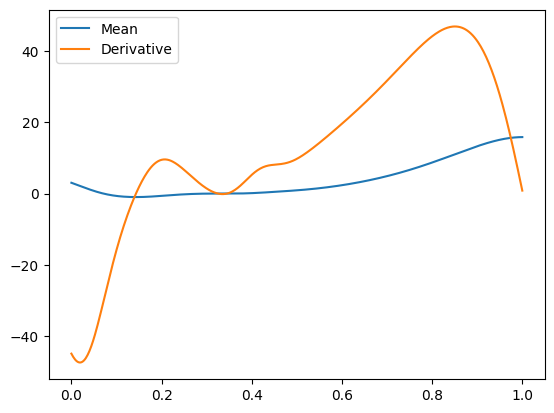

In [20]:
plt.plot(x, tf.squeeze(traj(x[..., None, None])), label="Sampled Trajectory")
plt.plot(x, tf.squeeze(model.predict_y(x[...,None])[0]), label="Posterior Mean")
plt.plot(x, y, label="Ground Truth")
plt.scatter(initial_data.query_points, initial_data.observations)
plt.legend()

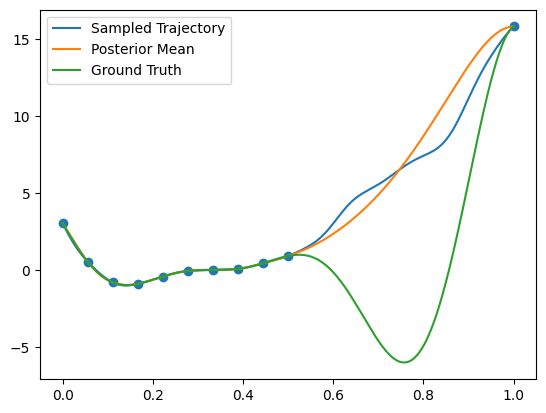

In [6]:
traj = traj_sampler.update_trajectory(traj)
plt.plot(x, tf.squeeze(traj(x[..., None, None])), label="Sampled Trajectory")
plt.plot(x, tf.squeeze(model.predict_y(x[...,None])[0]), label="Posterior Mean")
plt.plot(x, y, label="Ground Truth")
plt.scatter(initial_data.query_points, initial_data.observations)
plt.legend()

In [83]:
new_data = observer(tf.constant([[0.3]]))

In [70]:
new_data

Dataset(query_points=<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.3]], dtype=float32)>, observations=<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.01557672]], dtype=float32)>)